# 📊 Breast Cancer Prediction Dataset

*🔗 Fonte: [Breast Cancer Prediction Dataset - Kaggle](https://www.kaggle.com/datasets/merishnasuwal/breast-cancer-prediction-dataset)*

**Descrição:**
O câncer de mama é o câncer mais comum entre as mulheres no mundo. Ele representa 25% de todos os casos de câncer e afetou mais de 2,1 milhões de pessoas apenas em 2015. O câncer de mama começa quando células da mama começam a crescer descontroladamente. Essas células normalmente formam tumores que podem ser vistos em radiografias ou sentidos como nódulos na área da mama. O principal desafio para a detecção é classificar corretamente os tumores como malignos (cancerosos) ou benignos (não cancerosos).

**Objetivos:**
- Entender o conjunto de dados e realizar a limpeza (se necessário).
- Construir modelos de classificação para prever se o tipo de câncer é maligno ou benigno.
- Ajustar hiperparâmetros e comparar as métricas de avaliação de diferentes algoritmos de classificação.

---
### ⚙️ Importações e configuração

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")
os.environ["LOKY_MAX_CPU_COUNT"] = "2"

---
### 🔍 Carregar e visualizar os dados

In [2]:
df = pd.read_csv(f'breast_cancer.csv', sep=',')

print("🎲 Formato do dataset:", df.shape)
display(df.head())
print("\nℹ️ Informações do dataset:")
print(df.info())
print(f"\n📈 Estatísticas descritivas:")
display(df.describe().T.style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)))

🎲 Formato do dataset: (569, 6)


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0



ℹ️ Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB
None

📈 Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
mean_radius,569.000000,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.110000
mean_texture,569.000000,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.280000
mean_perimeter,569.000000,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.500000
mean_area,569.000000,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.000000
mean_smoothness,569.000000,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.163400
diagnosis,569.000000,0.627417,0.483918,0.000000,0.000000,1.000000,1.000000,1.000000


---
### 📌 Análise de Valores Únicos e Tipos de Colunas

In [3]:
print("📌 Quantidade de valores únicos em cada coluna:")
print(df.nunique())

📌 Quantidade de valores únicos em cada coluna:
mean_radius        456
mean_texture       479
mean_perimeter     522
mean_area          539
mean_smoothness    474
diagnosis            2
dtype: int64


---
## 📊 Pré-processamento

---
### 🧼 Converter e tratar valores ausentes e duplicados

In [4]:
# Remover linhas duplicadas, se houver
print(f"🔍 Removendo duplicatas...")
duplicatas = df.duplicated().sum()
if duplicatas > 0:
    df.drop_duplicates(inplace=True)
    print(f"➡️ {duplicatas} duplicatas removidas.")
else:
    print("➡️ Nenhuma duplicata encontrada.")

🔍 Removendo duplicatas...
➡️ Nenhuma duplicata encontrada.


In [5]:
# Substituir valores infinitos por NaN e depois remover ou imputar
print(f"🔍 Tratando valores infinitos...")
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Se restar algum NaN após substituir infinitos
nulos = df.isnull().sum().sum()
if nulos > 0:
    df.dropna(inplace=True)
    print(f"➡️ {nulos} valores nulos removidos.")
else:
    print("➡️ Nenhum valor nulo encontrado.")

🔍 Tratando valores infinitos...
➡️ Nenhum valor nulo encontrado.


---
### 📈 Análise exploratória (EDA)

In [6]:
cor_benigno = '#A865C9'
cor_maligno = '#f6abb6'

#### 🎯 Distribuição dos Diagnósticos
##### Gráfico de Barras 📊 e de Pizza 🍕

In [7]:
# Contagem e porcentagem
contagem_status = df['diagnosis'].value_counts()
porcentagem_status = contagem_status / contagem_status.sum() * 100

# Cores personalizadas
colors = [cor_maligno, cor_benigno]

# Criar subplots: 1 linha, 2 colunas
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "bar"}, {"type": "pie"}]],
    subplot_titles=("Distribuição de Diagnóstico", "Proporção de Diagnóstico")
)

# Gráfico de Barras
fig.add_trace(
    go.Bar(
        x=contagem_status.index,
        y=contagem_status.values,
        marker_color=colors,
        text=contagem_status.values,
        textposition='auto',
        showlegend=False
    ),
    row=1, col=1
)

# Gráfico de Pizza
fig.add_trace(
    go.Pie(
        labels=['Benigno (1)', 'Maligno (0)'],
        values=porcentagem_status.values,
        marker_colors=colors,
        hole=0.4
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    title_text="🎯 Diagnóstico de Câncer de Mama",
    width=1200,
    height=400
)

fig.show()

#### 📏 Histogramas de Variáveis Selecionadas

In [8]:
variaveis_histograma = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']

for var in variaveis_histograma:
    fig = px.histogram(
        df,
        x=var,
        color='diagnosis',
        color_discrete_sequence=[cor_benigno, cor_maligno],
        title=f'Distribuição de {var.replace("_", " ").title()} por Diagnóstico',
        subtitle=f'Maligno (0) e Benigno (1)',
    )
    fig.show()

#### 🎯 Scatter Plots para Variáveis Individuais

In [9]:
variaveis_scatter = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']

for var in variaveis_scatter:
    fig = px.scatter(
        data_frame=df,
        x=var,
        color='diagnosis',
        color_continuous_scale=[cor_maligno, cor_benigno],
        title=f'Relação entre {var.replace("_", " ").title()} e Diagnóstico',
        subtitle=f'Maligno (0) e Benigno (1)',
    )
    fig.show()

#### 🔥 Mapa de Calor das Correlações

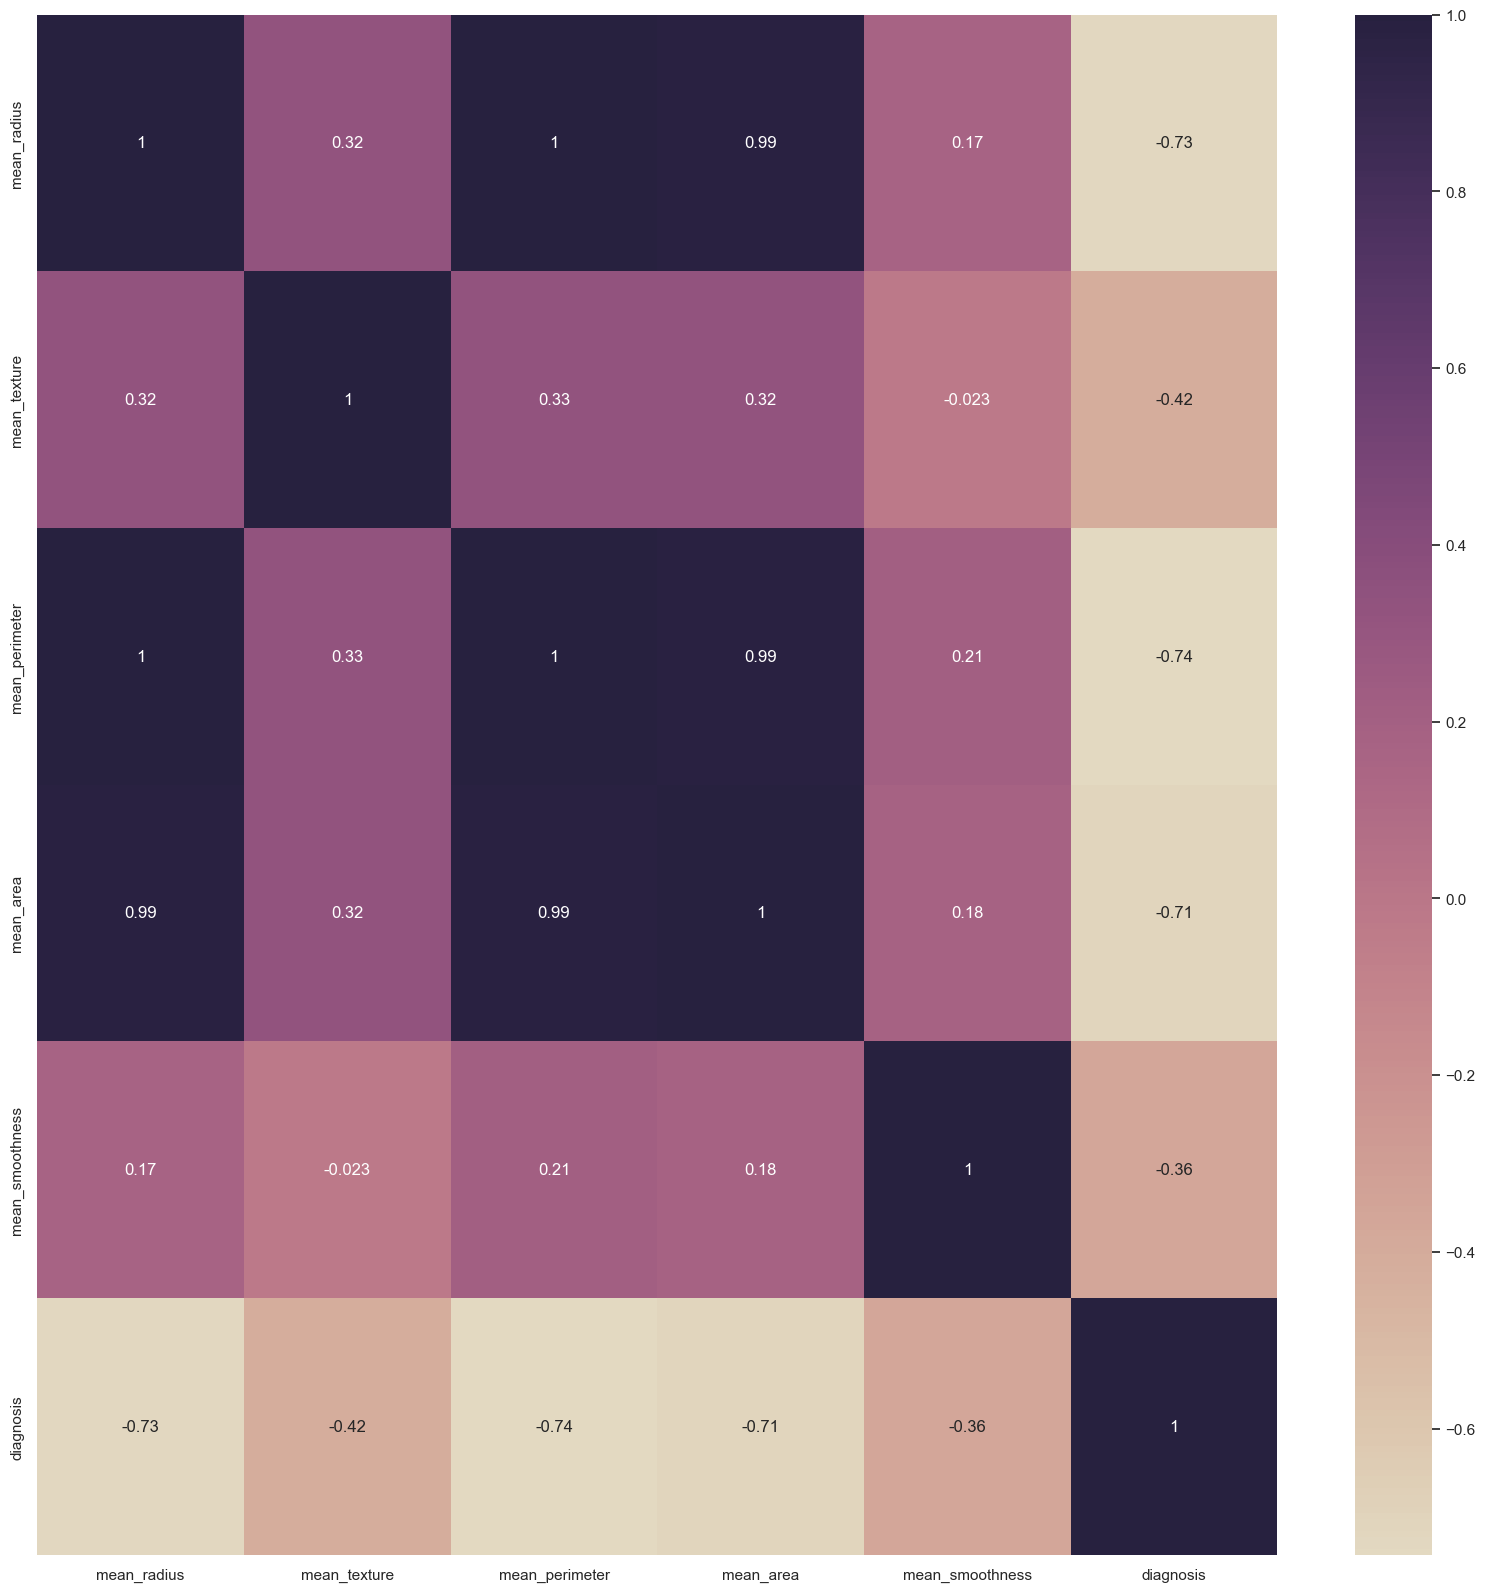

In [10]:
corr = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),annot=True)
plt.show()

cor_target = abs(corr["diagnosis"]) # Get the absolute value of the correlation
relevant_features = cor_target[cor_target>0.2] # Select highly correlated features (thresold = 0.2)
names = relevant_features.index.tolist() # Collect the names of the features
names.remove('diagnosis') # Drop the target variable from the results

#### 🎯 Boxplots Comparativos por Diagnóstico

In [11]:
variaveis_boxplot = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']

for var in variaveis_boxplot:
    fig = px.box(
        df,
        x='diagnosis',
        y=var,
        color='diagnosis',
        color_discrete_sequence=[cor_maligno, cor_benigno],
        title=f'Distribuição de {var.replace("_", " ").title()} por Diagnóstico',
        subtitle=f'Maligno (0) e Benigno (1)',
    )
    fig.show()

#### 📖 Conclusão da Análise Exploratória

- A distribuição dos diagnósticos mostra que há uma quantidade considerável de casos malignos e benignos, mas com uma predominância dos casos benignos.
- Variáveis como `radius_mean`, `perimeter_mean` e `area_mean` apresentam distribuições bem distintas entre tumores benignos e malignos, sugerindo que podem ser bons preditores.
- A análise de correlação indicou forte relação entre variáveis `radius_mean`, `perimeter_mean` e `area_mean`, o que pode impactar na escolha de atributos para o modelo.
- Não foram encontrados valores ausentes ou inconsistentes, e os dados estão prontos para o pré-processamento final e modelagem.

---
## 🧠 Treinamento dos modelos

### 🔎 Separação de Variáveis e Divisão dos Dados

In [12]:
# Variáveis preditoras (X) e alvo (y)
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

print("✅ Separação concluída!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

✅ Separação concluída!
X shape: (569, 5)
y shape: (569,)


### 🧪 Dividir os Dados em Treino e Teste

In [13]:
# Dividir 80% treino / 20% teste, mantendo a proporção das classes (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Divisão concluída!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

✅ Divisão concluída!
X_train shape: (455, 5)
X_test shape: (114, 5)


### 🔄 Padronizar os Dados

In [14]:
# Padronizar apenas após a divisão (evitar vazamento de dados)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Padronização concluída!")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

✅ Padronização concluída!
X_train_scaled shape: (455, 5)
X_test_scaled shape: (114, 5)


### 🚀 Treinar Vários Modelos e Comparar

In [15]:
# Dicionário com os modelos
modelos = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Dicionário para armazenar resultados
resultados = {}

# Função para plotar matriz de confusão bonita com Plotly
def plot_matriz_confusao(y_true, y_pred, titulo):
    cm = confusion_matrix(y_true, y_pred)
    fig = px.imshow(
        cm,
        text_auto=True,
        color_continuous_scale="Blues",
        labels=dict(x="Predito", y="Real", color="Contagem"),
        x=["Maligno (0)", "Benigno (1)"],
        y=["Maligno (0)", "Benigno (1)"],
        title=f"Matriz de Confusão - {titulo}",
        width=600,
        height=400,
    )
    fig.update_layout(title_x=0.5)
    fig.show()

# Treinar e avaliar cada modelo
for nome, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    resultados[nome] = acc
    print(f"✅ {nome} treinado com acurácia: {acc:.4f}")
    
    # Exibir matriz de confusão
    plot_matriz_confusao(y_test, y_pred, nome)

✅ Decision Tree treinado com acurácia: 0.8860


✅ K-Nearest Neighbors treinado com acurácia: 0.8947


✅ Random Forest treinado com acurácia: 0.9211


✅ Logistic Regression treinado com acurácia: 0.8596


✅ Gradient Boosting treinado com acurácia: 0.9123


### 📋 Comparação de Resultados

In [16]:
# Converter resultados em DataFrame para visualizar melhor
resultados_df = pd.DataFrame(
    resultados.items(),
    columns=["Modelo", "Acurácia"]
).sort_values(by="Acurácia", ascending=False)

# Exibir a tabela
display(resultados_df.style.background_gradient(cmap="Blues"))

fig = px.bar(
    resultados_df,
    x="Modelo",
    y="Acurácia",
    title="Comparação de Modelos - Acurácia",
    text_auto='.2f',
    color="Acurácia",
    color_continuous_scale="Blues"
)
fig.update_layout(xaxis_title="Modelos", yaxis_title="Acurácia", title_x=0.5)
fig.show()

,Modelo,Acurácia
2,Random Forest,0.921053
4,Gradient Boosting,0.912281
1,K-Nearest Neighbors,0.894737
0,Decision Tree,0.885965
3,Logistic Regression,0.859649


### 📈 Visualização dos critérios de parada do modelo

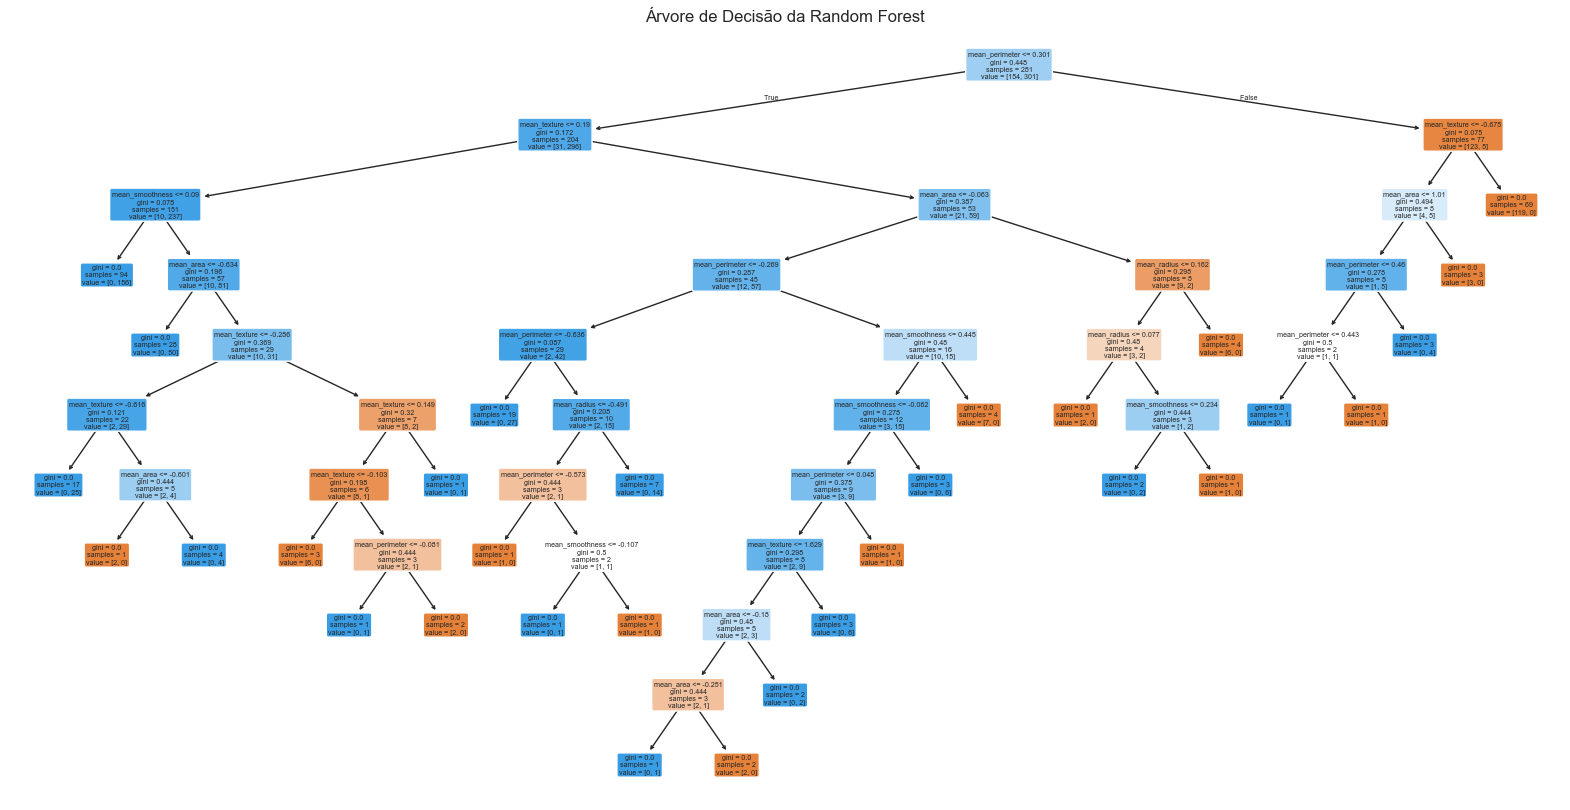

In [17]:
# Plotar a Random Forest
plt.figure(figsize=(20, 10))
plot_tree(modelos["Random Forest"].estimators_[0], filled=True, feature_names=X.columns, rounded=True)
plt.title("Árvore de Decisão da Random Forest")
plt.show()

## 🥒 Exportação do modelo para o formato pickle

In [18]:
with open('../backend/models/model.pkl', 'wb') as f:
    pickle.dump(modelos["Random Forest"], f)

with open('../backend/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### 📋 Teste dos arquivos exportados

In [ ]:
# Carregar modelo e scaler
with open('../backend/models/model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('../backend/models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

def predict(data):
    input_df = pd.DataFrame([data], columns=['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness'])
    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)[0]
    return "Benigno" if prediction == 1 else "Maligno"

benigno = [13.8, 15.7, 85.6, 520.1, 0.1]
print(f"🔍 Dados de entrada: {benigno}\nExpectativa: Benigno\nResultado: {predict(benigno)}\n")

maligno = [14.5, 20.0, 95.5, 600.2, 0.12]
print(f"🔍 Dados de entrada: {maligno}\nExpectativa: Maligno\nResultado: {predict(maligno)}")

🔍 Dados de entrada: [13.8, 15.7, 85.6, 520.1, 0.1]
Expectativa: Benigno
Resultado: Benigno

🔍 Dados de entrada: [14.5, 20.0, 95.5, 600.2, 0.12]
Expectativa: Maligno
Resultado: Maligno
